## Model

In [1]:
using Revise, ReachabilityAnalysis, SparseArrays, Plots
const RA = ReachabilityAnalysis
LazySets.set_ztol(Float64, 1e-14)

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1278


1.0e-14

In [2]:
function gearbox(; X0 = Hyperrectangle([0., 0., -0.0167, 0.003,  0., 0.],
                                       [0., 0.,  0.0001, 0.0001, 0., 0.]),
                   init = [(1, X0)])

    # variables
    vx = 1  # x velocity
    vy = 2  # y velocity
    px = 3  # x position
    py = 4  # y position
    I = 5   # accumulated impulse
    t = 6   # time

    # number of variables
    n = 5 + 1

    # constants
    Fs = 70.0  # shifting force on the sleeve [N]
    Tf = 1.0  # resisting moments on the second gear [N⋅m]
    # TODO where do the following values come from?
    ms = 3.2  # mass of the sleeve
    Rs = 0.08  # radius of the sleeve
    Jg₂ = 0.7  # inertia of the second gear
    Δp = -0.003  # horizontal (px) distance
    θ = 0.628318530717959  # included angle of the second gear [°]
    mg₂ = 18.1  # mass of the second gear
    ζ = 0.9  # coefficient of restitution

    # discrete structure (graph)
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 1, 1)
    add_transition!(automaton, 1, 1, 2)
    add_transition!(automaton, 1, 2, 3)

    # mode 1 ("free")
    A = zeros(n, n)
    b = zeros(n)
    A[px, vx] = 1.
    A[py, vy] = 1.
    b[vx] = Fs / ms
    b[vy] = - (Rs * Tf) / Jg₂
    b[t] = 1.
    invariant = HPolyhedron([
        HalfSpace(sparsevec([px], [1.], n), Δp),  # px <= Δp
        HalfSpace(sparsevec([px, py], [tan(θ), 1.], n), 0.),    # py <= -px * tan(θ)
        HalfSpace(sparsevec([px, py], [tan(θ), -1.], n), 0.)])  # py >= px * tan(θ)
    m_1 = @system(x' = Ax + b, x ∈ invariant)

    # mode 2 ("meshed")
    A = zeros(n, n)
    b = zeros(n)
    b[t] = 1.
    m_2 = @system(x' = Ax + b, x ∈ Universe(n))

    # common assignment matrix (requires individual modifications)
    A_template = zeros(n, n)
    for i in 3:6
        A_template[i, i] = 1.
    end
    denominator = ms * cos(θ)^2 + mg₂ * sin(θ)^2
    A_template[vx, vx] = (ms * cos(θ)^2 - mg₂ * ζ * sin(θ)^2) / denominator
    A_template[vx, vy] = (-(ζ + 1.) * mg₂ * sin(θ) * cos(θ)) / denominator
    A_template[vy, vx] = (-(ζ + 1.) * ms * sin(θ) * cos(θ)) / denominator
    A_template[vy, vy] = (mg₂ * sin(θ)^2 - ms * ζ * cos(θ)^2) / denominator
    A_template[I, vx] = ((ζ + 1.) * ms * mg₂ * sin(θ)) / denominator
    A_template[I, vy] = ((ζ + 1.) * ms * mg₂ * cos(θ)) / denominator

    # transition l1 -> l1
    # TODO what happened to the term '2nb' and the whole second constraint in the paper?
    guard = HPolyhedron([
        HalfSpace(sparsevec([px, py], [-tan(θ), -1.], n), 0.),     # py >= -px * tan(θ)
        HalfSpace(sparsevec([vx, vy], [-sin(θ), -cos(θ)], n), 0.)  # vx * sin(θ) + vy * cos(θ) >= 0
        ])
    A = copy(A_template)
    t1 = ConstrainedLinearMap(A, guard)

    # transition l1 -> l1
    # TODO same remark as with the other guard
    guard = HPolyhedron([
        HalfSpace(sparsevec([px, py], [-tan(θ), 1.], n), 0.),     # py <= px * tan(θ)
        HalfSpace(sparsevec([vx, vy], [-sin(θ), cos(θ)], n), 0.)  # vx * sin(θ) - vy * cos(θ) >= 0
        ])
    A = copy(A_template)
    A[vx, vy] *= -1.
    A[vy, vx] *= -1.
    A[I, vy] *= -1.
    t2 = ConstrainedLinearMap(A, guard)

    # transition l1 -> l2
    guard = HalfSpace(sparsevec([px], [-1.], n), -Δp)  # px >= Δp
    A = copy(A_template)
    A[vx, vx] = 0.
    A[vx, vy] = 0.
    A[vy, vx] = 0.
    A[vy, vy] = 0.
    A[I, vx] = A[I, vy] = ms
    t3 = ConstrainedLinearMap(A, guard)

    H = HybridSystem(automaton=automaton,
                     modes=[m_1, m_2],
                     resetmaps=[t1, t2, t3])

    return InitialValueProblem(H, init)
end

gearbox (generic function with 1 method)

## Safety properties

The goal is to show that the gears are meshed within a time frame of 0.2 [s] and that the bound
x 5 ≤ 20 [Nm] of the cumulated impulse is met. Using the monitor states free and meshed , and a
global clock t, this can be expressed as a safety property as follows: For all t ≥ 0.2, the monitor
should be in meshed . Under nonblocking assumptions, this means that t < 0.2 whenever the
monitor is not in meshed , i.e., when it is in free.


MES01: forbidden states: (free ∧ t ≥ 0.2) ∨ (x 5 ≥ 20)

In [ ]:
#=
# safety property
cond_free = is_contained_in(HalfSpace([0., 0., 0., 0., 0., 1.], 0.2))    # t <= 0.2
cond_global = is_contained_in(HalfSpace([0., 0., 0., 0., 1., 0.], 20.))  # I <= 20
property_free = Conjunction([cond_free, cond_global])
property_meshed = cond_global
property = Dict(1 => property_free, 2 => property_meshed)

# default options
options = Options(:T=>0.5, :property=>property)

return (system, options)
=#

---

## Results

In [3]:
using Polyhedra, CDDLib

┌ Warning: Replacing docs for `LazySets.HPolytope :: Union{Tuple{Union{HRepresentation{N}, Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `LazySets.HPolyhedron :: Union{Tuple{Union{HRepresentation{N}, Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{Union{HPolyhedron{N,VN} where VN<:AbstractArray{N,1}, HPolytope{N,VN} where VN<:AbstractArray{N,1}}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{VPolytope{N,VN} where VN<:AbstractArray{N,1}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227


In [4]:
X0_GRBX01 = Hyperrectangle(low=[0, 0, -0.0168, 0.0029, 0, 0], high=[0, 0, -0.0166, 0.0031, 0, 0])
X0_GRBX01 = Hyperrectangle(low=[0, 0, -0.01675, 0.00285, 0, 0], high=[0, 0, -0.01665, 0.00315, 0, 0]);

-----

In [5]:
#=
function first_empty_intersection(sol, invariant)
    k = 1
    @inbounds for R in sol
        isdisjoint(set(R), invariant) && break
        k += 1
    end
    return k
end
=#

In [6]:
#=
ivp = gearbox(X0=X0_GRBX01);

m1 = mode(system(ivp), 1)
m1_unconstrained = @system(x' = m1.A * x + m1.c)
m1_inv = stateset(m1)

m2 = mode(system(ivp), 2);
m2_unconstrained = @system(x' = m2.A * x + m2.c);
m2_inv = stateset(m2);

alg = LGG09(δ=1e-3, template=OctDirections(6))

#sol1 = solve(IVP(m1_unconstrained, X0_GRBX01), tspan=0 .. 0.1, alg=alg);
sol1 = solve(IVP(m1_unconstrained, X0_GRBX01), tspan=0 .. 0.2, alg=alg);

plot([set(Projection(x, [3, 4])) for x in sol1], color=:blue)

idx = first_empty_intersection(sol1, m1_inv)
F = Flowpipe(view(sol1.F, 1:(idx - 1)));
=#

Now we need to check if some of the reach-sets in `sol1` have empty intersection with the invariant `m1_inv`.

---

## Requirements

In [5]:
function req1(sol)
    all_idx = findall(x -> x == 1, location.(sol))  # free mode
    for idx in all_idx
        verif = all([!(0.2 ∈ tspan(R)) for R in sol[idx]])
        !verif && return false
    end
    return true
end

function req2(sol)
    return ρ(sparsevec([5], [1.0], 6), sol) < 20.0
end

req2 (generic function with 1 method)

### GRBX01-MES01 dense-time

In [8]:
const boxdirs = BoxDirections{Float64, Vector{Float64}}(6);
const octdirs = CustomDirections([Vector(vi) for vi in OctDirections(6)]);

using LazySets: HalfSpace

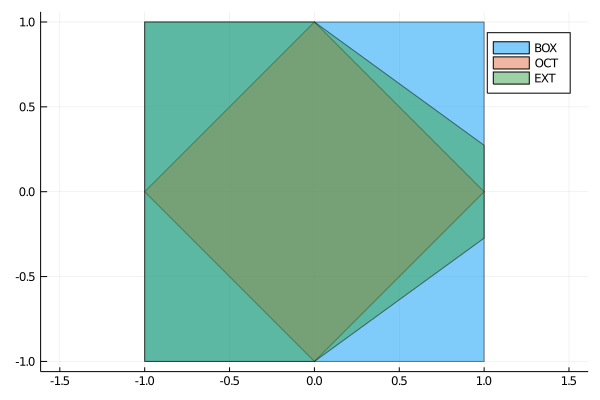

In [9]:
px, py, n, θ = 3, 4, 6, 0.628318530717959
vec1 = Vector(sparsevec([px, py], [tan(θ), 1.], n))
vec2 = Vector(sparsevec([px, py], [tan(θ), -1.], n))
const extdirs = vcat(collect(boxdirs), [vec1, vec2]) |> CustomDirections;

# px - py plane
plot(Projection(HPolytope([HalfSpace(v, 1.0) for v in boxdirs]), vars=(3, 4)), lab="BOX")
plot!(Projection(HPolytope([HalfSpace(v, 1.0) for v in octdirs]), vars=(3, 4)), lab="OCT", ratio=1.)
plot!(Projection(HPolytope([HalfSpace(v, 1.0) for v in extdirs]), vars=(3, 4)), lab="EXT", ratio=1.)

In [20]:
GC.gc()
sol = nothing

ivp = gearbox(X0=X0_GRBX01);

@time sol = solve(ivp, max_jumps=2,
                  clustering_method=LazyClustering(1), #, [1,1,2,2,1,1]),
                  intersect_source_invariant=true,
                  intersection_source_invariant_method=HRepIntersection(), # TemplateHullIntersection(extdirs),
                  intersection_method=HRepIntersection(), # TemplateHullIntersection(extdirs),
                  tspan = 0 .. 0.25,
                  alg=LGG09(δ=0.0001, template=extdirs));

@show req1(sol)
@show req2(sol)
@show length(sol)
@show numrsets(sol)
@show ρ(sparsevec([5], [1.0], 6), sol)

length(waiting_list) = 1
number of sets that jump: 9
Array{ReachSet{Float64,ConvexHullArray{Float64,HPolytope{Float64,Array{Float64,1}}}},1}


MethodError: MethodError: no method matching apply(::DiscreteTransition{Array{Float64,2},ZeroSet{Float64},HPolyhedron{Float64,SparseVector{Float64,Int64}},HPolyhedron{Float64,SparseVector{Float64,Int64}},HPolyhedron{Float64,SparseVector{Float64,Int64}}}, ::ConvexHullArray{Float64,HPolytope{Float64,Array{Float64,1}}}, ::HRepIntersection)
Closest candidates are:
  apply(::DiscreteTransition, !Matched::ReachabilityAnalysis.AbstractLazyReachSet, ::ReachabilityAnalysis.AbstractIntersectionMethod) at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Hybrid/transitions.jl:123
  apply(!Matched::DiscreteTransition{var"#s352",var"#s351",GT,IT⁻,IT⁺} where var"#s351"<:ZeroSet where var"#s352"<:IdentityMap, ::ConvexHullArray{N,PT}, ::HRepIntersection) where {N, PT<:AbstractPolytope{N}, GT<:AbstractPolyhedron{N}, IT⁻<:AbstractPolyhedron{N}, IT⁺<:AbstractPolyhedron{N}} at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Hybrid/transitions.jl:173
  apply(::DiscreteTransition{var"#s352",var"#s351",GT,IT⁻,IT⁺} where var"#s351"<:ZeroSet where var"#s352"<:(AbstractArray{T,2} where T), !Matched::AbstractPolytope{N}, ::HRepIntersection) where {N, GT<:AbstractPolyhedron{N}, IT⁻<:AbstractPolyhedron{N}, IT⁺<:AbstractPolyhedron{N}} at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Hybrid/transitions.jl:229
  ...

In [18]:
numrsets(sol)

1151

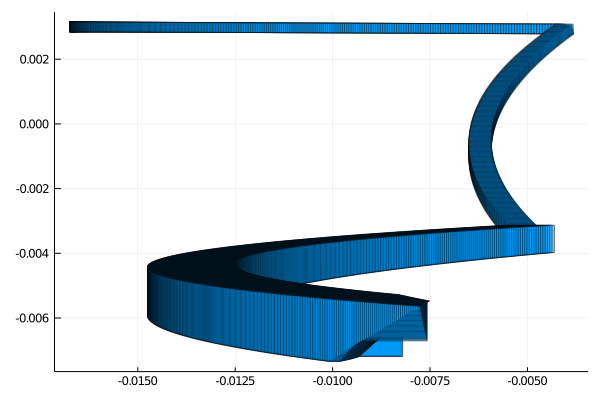

In [19]:
plot(sol, vars=(3, 4))

----

In [62]:
GC.gc()
sol = nothing

X0_GRBX01s = split(X0_GRBX01, [1,1,1,2,1,1])

ivp = gearbox(X0=X0_GRBX01);

@time sol = solve(ivp, max_jumps=500,
                  clustering_method=BoxClustering(3, [1,1,2,2,1,1]),
                  intersect_source_invariant=true,
                  #intersection_source_invariant_method=TemplateHullIntersection(boxdirs),
                  intersection_method=TemplateHullIntersection(boxdirs),
                  tspan = 0 .. 0.25,
                  alg=BOX(δ=0.0001)) #  template=extdirs));

@show req1(sol)
@show req2(sol)
@show length(sol)
@show numrsets(sol)
@show ρ(sparsevec([5], [1.0], 6), sol)

length(waiting_list) = 1
number of sets that jump: 9
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
length(waiting_list) = 6
number of sets that jump: 6
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
length(waiting_list) = 11
number of sets that jump: 19
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
length(waiting_list) = 17
number of sets that jump: 11
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
number of sets that jump: 18
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
length(waiting_list) = 22
length(waiting_list) = 21
length(waiting_list) = 20
length(waiting_list) = 19
length(waiting_list) = 18
length(waiting_list) = 17
length(waiting_list) = 16
number of sets that jump: 11
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
number of sets that jump: 17
Array

length(waiting_list) = 14
length(waiting_list) = 13
length(waiting_list) = 12
length(waiting_list) = 11
number of sets that jump: 34
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
length(waiting_list) = 10
number of sets that jump: 62
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
length(waiting_list) = 15
length(waiting_list) = 14
length(waiting_list) = 13
length(waiting_list) = 12
length(waiting_list) = 11
length(waiting_list) = 10
length(waiting_list) = 9
number of sets that jump: 20
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
length(waiting_list) = 15
number of sets that jump: 15
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
number of sets that jump: 18
Array{ReachSet{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1}
length(waiting_list) = 20
length(waiting_list) = 19
length(waiting_list) = 18
length(waiting_

AssertionError: AssertionError: radius must not be negative

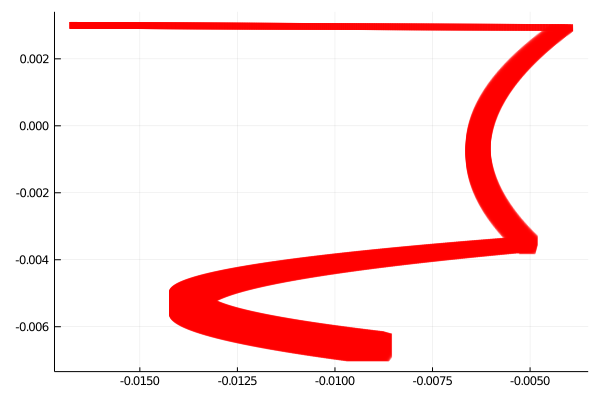

In [36]:
plot(sol[1], vars=(3, 4), lw=0.0, color=:red)
plot!(sol[2], vars=(3, 4), lw=0.0, color=:red)
plot!(sol[3], vars=(3, 4), lw=0.0, color=:red)
plot!(sol[4], vars=(3, 4), lw=0.0, color=:red)

In [ ]:
plot(sol[2][end], vars=(3, 4))

In [ ]:
GC.gc()
sol = nothing

ivp = gearbox(X0=X0_GRBX01);

@time sol = solve(ivp, max_jumps=100,
                  clustering_method=BoxClustering(3,[1,1,2,2,1,1]),
                  intersect_source_invariant=true,
                  intersection_source_invariant_method=TemplateHullIntersection(extdirs),
                  intersection_method=TemplateHullIntersection(extdirs),
                  tspan = 0 .. 0.25,
                  alg=LGG09(δ=0.0004, template=extdirs));

@show req1(sol)
@show req2(sol)
@show length(sol)
@show numrsets(sol)
@show ρ(sparsevec([5], [1.0], 6), sol)

In [ ]:
numrsets(sol)

----

RESULTS (dense time)

```julia
GC.gc()
sol = nothing

ivp = gearbox(X0=X0_GRBX01);

@time sol = solve(ivp, max_jumps=500,
                  clustering_method=BoxClustering(3),
                  intersect_source_invariant=true, # 
                  intersection_method=TemplateHullIntersection(boxdirs),
                  tspan = 0 .. 0.25,
                  alg=BOX(δ=1e-4));

@show req1(sol)
@show req2(sol)
@show length(sol)
@show numrsets(sol)
@show ρ(sparsevec([5], [1.0], 6), sol)

 19.625569 seconds (40.88 M allocations: 3.845 GiB, 8.33% gc time)
req1(sol) = true
req2(sol) = false
length(sol) = 198
numrsets(sol) = 162599
ρ(sparsevec([5], [1.0], 6), sol) = 20.20340537794677
20.20340537794677
```

# ---


```julia
GC.gc()
sol = nothing

ivp = gearbox(X0=X0_GRBX01);

@time sol = solve(ivp, max_jumps=500,
                  clustering_method=BoxClustering(3, [1,1,2,2,1,1]),
                  intersect_source_invariant=true,
                  intersection_method=TemplateHullIntersection(boxdirs),
                  tspan = 0 .. 0.25,
                  alg=BOX(δ=1e-4));

@show req1(sol)
@show req2(sol)
@show length(sol)
@show numrsets(sol)
@show ρ(sparsevec([5], [1.0], 6), sol)

 47.013049 seconds (98.57 M allocations: 9.128 GiB, 11.14% gc time)
req1(sol) = true
req2(sol) = true
length(sol) = 465
numrsets(sol) = 421194
ρ(sparsevec([5], [1.0], 6), sol) = 19.93663009289752
19.93663009289752
```

In [ ]:
GC.gc()
sol = nothing

ivp = gearbox(X0=X0_GRBX01);

@time sol = solve(ivp, max_jumps=500,
                  clustering_method=LazyClustering(1),
                  intersect_source_invariant=true, # 
                  intersection_method=TemplateHullIntersection(boxdirs),
                  tspan = 0 .. 0.25,
                  alg=LGG09(δ=1e-3, template=boxdirs));

@show req1(sol)
@show req2(sol)

In [ ]:
ρ(sparsevec([5], [1.0], 6), sol)

In [ ]:
location.(sol);

### GRBX01-MES01 discrete

In [ ]:
sol = nothing
GC.gc()

In [ ]:
ivp = gearbox(X0=X0_GRBX01);

@time sol = solve(ivp, max_jumps=500,
                  clustering_method=BoxClustering(2),
                  intersect_source_invariant=true,
                  intersection_method=TemplateHullIntersection(boxdirs),
                  tspan = 0 .. 0.25,
                  alg=BOX(δ=1e-4, approx_model=NoBloating()));

@show req1(sol)
@show req2(sol)
@show length(sol)
@show numrsets(sol)
@show ρ(sparsevec([5], [1.0], 6), sol)

In [ ]:
plot(sol, vars=(3, 4), lw=0.0, color=:red)

---

RESULT:

```julia

ivp = gearbox(X0=X0_GRBX01);

@time sol = solve(ivp, max_jumps=500,
                  clustering_method=BoxClustering(2),
                  intersect_source_invariant=true,
                  intersection_method=TemplateHullIntersection(boxdirs),
                  tspan = 0 .. 0.25,
                  alg=BOX(δ=1e-4, approx_model=NoBloating()));

@show req1(sol)
@show req2(sol)
@show length(sol)
@show numrsets(sol)
@show ρ(sparsevec([5], [1.0], 6), sol)

  6.694961 seconds (11.89 M allocations: 1.060 GiB, 5.02% gc time)
req1(sol) = true
req2(sol) = true
length(sol) = 36
numrsets(sol) = 26103
ρ(sparsevec([5], [1.0], 6), sol) = 19.657207580755298
19.657207580755298

```

### GRBX02-MES01 dense-time

In [ ]:
GC.gc()
sol2 = nothing

ivp2 = gearbox(X0=X0_GRBX02);

@time sol2 = solve(ivp2, max_jumps=500,
                  clustering_method=BoxClustering(3, [1,1,2,2,1,1]),
                  intersect_source_invariant=true, #false
                  #intersection_method=TemplateHullIntersection(BoxDirections(6)),
                  intersection_method=TemplateHullIntersection(dirs),
                  tspan = 0 .. 0.25,
                  alg=BOX(δ=1e-4));

In [ ]:
req1(sol2) && req2(sol2)

In [ ]:
ρ(sparsevec([5], [1.0], 6), sol)

### GRBX02-MES01 discrete-time

In [ ]:
GC.gc()
sol2 = nothing

ivp2 = gearbox(X0=X0_GRBX02);

@time sol2 = solve(ivp2, max_jumps=500,
                  clustering_method=BoxClustering(3, [1,1,2,2,1,1]),
                  intersect_source_invariant=true,
                  #intersection_method=TemplateHullIntersection(BoxDirections(6)),
                  intersection_method=TemplateHullIntersection(dirs),
                  tspan = 0 .. 0.21,
                  alg=BOX(δ=1e-4, approx_model=NoBloating()));

In [ ]:
req1(sol2) && req2(sol2)

In [ ]:
typeof(sol2)

In [ ]:
ρ(sparsevec([5], [1.0], 6), sol)

In [ ]:
tspan.(sol2)

In [ ]:
req2(sol2)

In [ ]:
tspan(sol)

In [ ]:
numrsets(sol)

In [ ]:
plot(sol[1], vars=(3, 4))
plot!(sol[5], vars=(3, 4))
plot!(sol[20], vars=(3, 4))

In [ ]:
plot(sol[1], vars=(3, 4))
plot!(sol[2], vars=(3, 4))
plot!(sol[3], vars=(3, 4))
plot!(sol[4], vars=(3, 4))
plot!(sol[5], vars=(3, 4))

In [ ]:
# solve first mode
#H = system(ivp);
#S1 = mode(H, 1);
#sol = solve(@ivp(S1, x(0) ∈ X0_GRBX01), tspan = 0 .. 1.0, alg=BOX(δ=1e-3));

In [ ]:
length(sol)

In [ ]:
out = [RA._Projection(set(sol[1], i), (3, 4)) for i in 1:length(sol[1])];
out2 = [RA._Projection(set(sol[2], i), (3, 4)) for i in 1:length(sol[2])];
out3 = [RA._Projection(set(sol[3], i), (3, 4)) for i in 1:length(sol[3])];

In [ ]:
plot(out, xlab="x", ylab="y", color=:blue);
plot!(out2, color=:blue);
plot!(out3, color=:blue)

In [ ]:
stateset(modes(ivp, 1.s))

In [ ]:
stateset(mode(ivp, 1))

In [ ]:
dirs = OctDirections(6)
sol = solve(ivp,
            tspan = 0.0 .. 0.1,
            alg=LGG09(δ=1e-4, template=dirs));

## Reachability settings

### GRBX01

In [ ]:
X0 = (0 .. 0) × (0 .. 0) × (-0.0168 .. -0.0166) × (0.0029 .. 0.0031) × (0 .. 0);

### GRBX02

In [ ]:
X0 = (0 .. 0) × (0 .. 0) × (-0.01675 .. -0.01665) × (0.00285 .. 0.00315) × (0 .. 0);